# DSCI 563 Lab Assignment 3: Blogs

## Assignment Objectives

In this assignment you will
- Convert a unlabeled blog corpus into a BOW representation
- Test whether dimensionality reduction with SVD preserves corpus variation in the context of clustering 
- Explore the corpus using the topics produced by an LDA topic model

### How does this relate to what we're doing in class?

On Monday, we took a look at how we can represent a document with a bag-of-words representation, and how that doesn't really capture document similarities.  Part 1 will have you create a bag of words representation, and then condense it using SVD, performing clustering on the resulting vectors.

On Wednesday, we will look at Latent Dirichlet Allocation as a way of clustering documents without an intermediate vector representation.  Part 2 has you create an LDA model for the same dataset you ran SVD on, so that you can compare and contrast the results.

## Getting Started

Run the code below to access relevant modules (you can add to this as needed)

In [1]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation
from sklearn.preprocessing import normalize
import zipfile
import re
from nltk import word_tokenize
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from random import seed

# Reproducibility
np.random.seed(0)
seed(0)

## Tidy Submission

rubric={mechanics:1}

To get the marks for tidy submission:

- Submit the assignment by filling in this jupyter notebook with your answers embedded
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions)
- Except you should not put the data in your lab repo, instead define the `path_to_data` below
- This is a *paired lab* - you should complete this lab with a partner (a small number of 3-person teams is also ok).

### Part 0: Prepare the corpus

#### Assignment 0.1
rubric={accuracy:3,efficiency:1, quality:1}

A zipped text file containing 8752 blog posts that we will use for this lab is provided in the data directory [here](https://github.ubc.ca/MDS-CL-2024-25/DSCI_563_unsup-learn_students/tree/master/data/blogposts.zip). Download the zip-file but **don't push the data to github** (when grading your lab, the TA will otherwise end up with hundreds of megabytes of unwanted data, when pulling all the student repos). Update the `PATH_TO_DATA` variable below:

In [2]:
PATH_TO_DATA = r"blogposts.zip"

In order to read the data, you should initialize a `ZipFile` object provided in the [zipfile]() module. You should first initialize a `ZipFile` object for the `blogposts.zip`. You can then use the member function `ZipFile.open()` to open the file `blogposts.txt` which is part of the zip archive `blogposts.zip`. You can then the the data in the usual way using the `read()` member function of the file object. 

**Note** that `read()` will return a `bytes` object, not a string. You will need to [decode](https://stackabuse.com/convert-bytes-to-string-in-python/) the data into `utf-8`. Since the data in `blogposts.txt` is not entirely clean, you will need to use the option `errors="ignore"`, when decoding. Otherwise, you'll get a `UnicodeDecodeError` error. 

Store the text in the file into a variable `data`. 

After reading the data, you should convert it into a scipy sparse matrix format (i.e. the output of Scikit Learn vectorizers - see practical work 5) where each row is a text and each column the count of words in the corpus. Each post is enclosed in an XML `<post>` tag which should not be included. For efficiency and quality, we strongly recommend you extract the individual text strings corresponding to each text using `re.finditer` and `MatchObject.group` methods.  As with all regexes, it's fine to take a look at the data before creating the regex - see what you're actually working with! 

Your final representation vectors should:

- Be a bag of words
- Be all lowercase
- Have no punctuation
- Have no words that appear in fewer than 10 different texts
- Have no words that appear in more than 20% of the texts

The Scikit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is a good choice for doing this (it has options for all of the above), though you don't have to use it if you prefer to do something else. 

Store your vectorized blog posts as a matrix `post_X`.

In [8]:
# Reading the data from the zip file
with zipfile.ZipFile(PATH_TO_DATA, 'r') as zf:
    with zf.open('blogposts.txt') as file:
        data = file.read().decode('utf-8', errors="ignore")

In [11]:
# Adjusting the regex to handle potential whitespace and newlines in <post> tags
posts = [match.group(1) for match in re.finditer(r"<post.*?>(.*?)</post>", data, re.DOTALL)]

# Check the first few extracted posts to ensure the regex works now
posts[0]

'\r\n\r\n\t \r\n      I recently lost my job. I sort of wanted to lose it actually. Kind of like a relationship that no longer works. Im looking for a job now that doesnt involve much responsibility. too bad the nearest hot topics is at least 2 hours away. I wouldnt have to dress up for the job interview. when no one else is at home I like to play "setting sun" by the chemical brothers thru one blown speaker really loud while I perfect my robot dance. it keeps my neighbours on theyre toes. Im convinced one of my neighbours is actually a pirate.he has a beard,swords and exotic birds.he\'s an eyepatch away from pillaging the neighbourhood. I special ordered my monochrome black chuck taylor hi-tops, for job interviews and work.hard to find vegan work shoes. my new favorite band is The Shins, but Oh Inverted World! era, I didnt like Chutes Too Narrow as much as the critics. its BeachBoys-esque in a an updated indie rock way, Like another favorite band of mine, Dios. I started cutting my ow

In [12]:
# Preprocessing the extracted posts: removing extra whitespace, newlines, and leading/trailing spaces
cleaned_posts = [re.sub(r'\s+', ' ', post).strip() for post in posts]

# Checking the first few cleaned posts to verify preprocessing
cleaned_posts[0]

'I recently lost my job. I sort of wanted to lose it actually. Kind of like a relationship that no longer works. Im looking for a job now that doesnt involve much responsibility. too bad the nearest hot topics is at least 2 hours away. I wouldnt have to dress up for the job interview. when no one else is at home I like to play "setting sun" by the chemical brothers thru one blown speaker really loud while I perfect my robot dance. it keeps my neighbours on theyre toes. Im convinced one of my neighbours is actually a pirate.he has a beard,swords and exotic birds.he\'s an eyepatch away from pillaging the neighbourhood. I special ordered my monochrome black chuck taylor hi-tops, for job interviews and work.hard to find vegan work shoes. my new favorite band is The Shins, but Oh Inverted World! era, I didnt like Chutes Too Narrow as much as the critics. its BeachBoys-esque in a an updated indie rock way, Like another favorite band of mine, Dios. I started cutting my own hair again (and dyi

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# your code here

# Vectorizing the cleaned posts
vectorizer = CountVectorizer(
    lowercase=True,
    token_pattern=r'\b\w+\b',  # Match words only
    min_df=10,  # Appear in at least 10 texts
    max_df=0.2  # Appear in at most 20% of texts
)

# Fitting and transforming the data to a sparse matrix
post_X = vectorizer.fit_transform(cleaned_posts)

# Output the shape of the resulting sparse matrix
post_X.shape

(8752, 14939)

Print out the shape of your matrix when you're done. You should end up with a sparse matrix with 8752 rows and about 14911 columns (it is okay if the second number is not exactly the same, but it should be close!):

In [16]:
assert post_X.shape[0] == 8752
assert 14000 < post_X.shape[1] and post_X.shape[1] < 15000
print("Success")

Success


### Part 1: Clustering with dimensionality reduced vectors

#### 1.1
rubric={accuracy:1}

L2 normalize the matrix `post_X` from Exercise 1 using [`sklearn.preprocessing.normalize`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html). Make sure that you are normalizing w.r.t. to the correct axis. **Hint** there are 8752 blog posts. 

You should preserve the original count matrix for later, so don't overwrite it. Instead store the normalized matrix as `post_X_norm`.

In [17]:
from sklearn.preprocessing import normalize

# your code here
# use  `normalize` using `post_X`; 

# L2 normalize the matrix along the rows (axis=1)
post_X_norm = normalize(post_X, axis=1, norm='l2')

In [18]:
post_X_norm.shape

(8752, 14939)

Assertion to check your code:

In [28]:
post_X_norm[0]  # --> sparse matrix 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 146 stored elements and shape (1, 14939)>

In [29]:
# NOTE: a.toarray() or a.A 
post_X_norm[0].toarray()  # --> array([[0., 0., 0., ..., 0., 0., 0.]])

array([[0., 0., 0., ..., 0., 0., 0.]])

In [31]:
np.linalg.norm(post_X_norm[0].toarray())  # --> return l2 norm by default

np.float64(0.9999999999999999)

In [32]:
assert np.abs(np.linalg.norm(post_X_norm[0].toarray()) - 1) < 0.0001
print("Success!")

Success!


#### 1.2

rubric={accuracy:2,viz:1}

Next, use the elbow method to identify a good *k* to cluster your blog data using k-means. With this much data, you will need to use [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) instead of regular KMeans for this. You can increase the batch size to get a smoother curve, 500 should work well. You'll want to explore larger values of $k$ than the example in the clustering lecture, though don't go any higher than 100. You can use the code from the clustering lecture, with appropriate modifications.  Note - this can take a bit of time to cluster the data (it took about 2 minutes on my laptop).

- `batch_size = 500`
- `n_clusters = k` where $2 \leq k\leq 50$: `kmeanses = MiniBatchKMeans(n_clusters=k,batch_size=500,random_state=0).` 
- `inertia_` is defined as the sum of square distances of samples to their nearest neighbor: `kmeanses.inertia_`

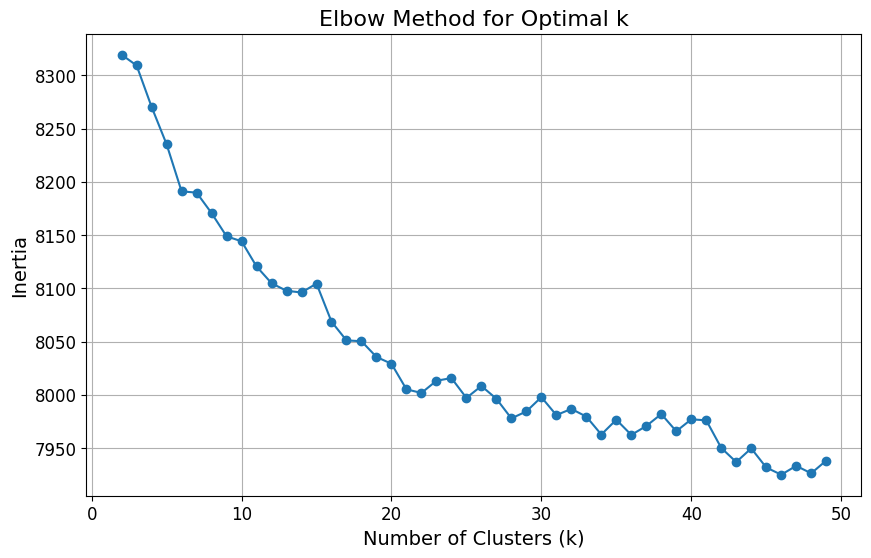

In [36]:
# your code here
def plot_inertia(kmeanses, start, end):
    '''plot the inertia of the provided set of k-means which should correspond to the range of
    k values provided by start and end. No return value'''
    ks = range(start, end)
    inertias = [kmeans.inertia_ for kmeans in kmeanses]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.title('Elbow Method for Optimal k', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

# Define the range for k
start = 2
end = 50
    
# List to store MiniBatchKMeans models
kmeanses = []
for k in range(start, end):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=0)
    kmeans.fit(post_X_norm)
    kmeanses.append(kmeans)

# Plotting inertia values for the elbow method
plot_inertia(kmeanses, start, end)

#### 1.3
rubric={accuracy:2,quality:1}

In this exercise you're going to be comparing different clusterings of the dataset to see if they are consistent, using the [adjusted rand index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) (ARI).  Note that the ARI is not really comparable across different numbers of clusters, so you'll have to stick to a single $k$ for the rest of this exercise, based on what you saw in 1.2. The ARI will be negative if the proposed clusters are very different, and closer to 1.0 if they are nearly the same.  Depending on your elbow, among other factors, you could get wildly different mean ARIs, but it should be positive, at least - if it isn't, you may want to pick a different value of k.  In the next section, you'll have the opportunity to tune some of the other values.

First, you're going to be looking at the consistency of clustering across different random iterations of k-means with the same data and parameters. You should run at least 10 different runs of k-means (again using MiniBatchKMeans), exhaustively calculate the pairwise ARI for the resulting label set, and print out an average. It would be a good idea to use a function here, especially since you'll need to do this again later.

In order to compare two different clusterings, you should feed in the `labels_` arrays from different clusterings to the `adjusted_rand_score` function.

- using a single $k$
- `labels_`: `MiniBatchKMeans(n_clusters=k, batch_size=50, max_no_improvement=50,random_state=i).fit(X).labels_`
- at least 10 different runs of k-means, exhaustively calculate the *pairwise* ARI for the resulting label set: `adjusted_rand_score(r0,r1), adjusted_rand_score(r0,r2), adjusted_rand_score(r0,r3), ..., adjusted_rand_score(r2,r3), adjusted_rand_score(r2,r4), ..., adjusted_rand_score(r7,r8), ..., adjusted_rand_score(r8,r9)`
- print out an average


*The Rand index or Rand measure (named after William M. Rand) in statistics is a measure of the similarity between two data clusterings.* (source: https://en.wikipedia.org/wiki/Rand_index)


ARI is a symmetric measure: `adjusted_rand_score(a, b) == adjusted_rand_score(b, a)`

In [39]:
from sklearn.metrics import adjusted_rand_score

K = 30 # number of cluster (you can decide the different number)

# your code here
def get_ari(n, X):

    # 1. Perform clustering n times
    kmeanses = []
    for i in range(n):
        kmeans = MiniBatchKMeans(
            n_clusters=k, batch_size=50, max_no_improvement=50, random_state=i
        ).fit(X)
        kmeanses.append(kmeans)

    # 2. Compute pairwise ARIs
    aris = []
    for i in range(n):
        for j in range(i + 1, n):
            ari = adjusted_rand_score(kmeanses[i].labels_, kmeanses[j].labels_)
            aris.append(ari)

    # 3. Return mean ARI
    return sum(aris) / len(aris)

print("Mean ARI:", get_ari(10, post_X_norm)) # 10 = random state; (1..10)

Mean ARI: 0.4960327673380925


#### 1.4 (Optional)
rubric={reasoning:1}

There are a few hyperparameters for [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) which will influence clustering performance: e.g. `max_no_improvement`.

Test a few of the parameters of the $k$-means (other than $k$), trying to improve the consistency calculations from 1.3 (you should get to `> 0.4`) and discuss any major effects in the markdown box below. Keep the best scoring parameters in your final version; you'll be using them for the result of this exercise.

#### 1.5 (Optional)
rubric= {reasoning:1}

Write a function that gives you lists of posts for a given clustering of the data. Using the parameters you choose above, do a run of k-means, select a cluster of medium size (it shouldn't be the largest or the smallest), print out the list of post ids, and inspect texts from that cluster (at least 5) until you can identify some commonality among posts in the cluster. If you can't make any sense of the cluster, try another one; it might also help to compare the cluster you pick with another. Write your conclusion in the box below, providing some examples of the language from different posts.

In [ ]:
### Your code here

#### 1.6
rubric= {accuracy:1}

Now use truncated singular value decomposition to lower the dimensionality of the dataset, with k=500. You should use the original data matrix `post_X` here. Store the resulting `np.array` as `post_X_500`.

`TruncatedSVD` https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html: `n_components = 500`

<!-- Desired dimensionality of output data. Must be strictly less than the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended. -->

In [40]:
# your code here

# Using TruncatedSVD to lower the dimensionality of the dataset
svd = TruncatedSVD(n_components=500, random_state=0)

# Applying fit_transform on the original data matrix post_X
post_X_500 = svd.fit_transform(post_X)

# Displaying the shape of the reduced matrix
post_X_500.shape

(8752, 500)

#### 1.7
rubric= {accuracy:1}

Plot the singular values of `post_X_500`, and pick a sensible new dimensionality, n, n < k, based on what you see (using again the elbow method)

- plot the singular values (`singular_values_`) where $k=500$
- pick a sensible new dimensionality $n$ where  $n < k$

**The singular value decomposition (SVD) of an $m \times n$ matrix $\mathbf{M}$ is a factorization of the form  ${\displaystyle \mathbf {U\Sigma V^{*}} }$, 
where the diagonal entries ${\displaystyle \sigma _{i}=\Sigma _{ii}}$ of $\mathbf{\Sigma}$ are known as the singular values of $\mathbf {M}$**

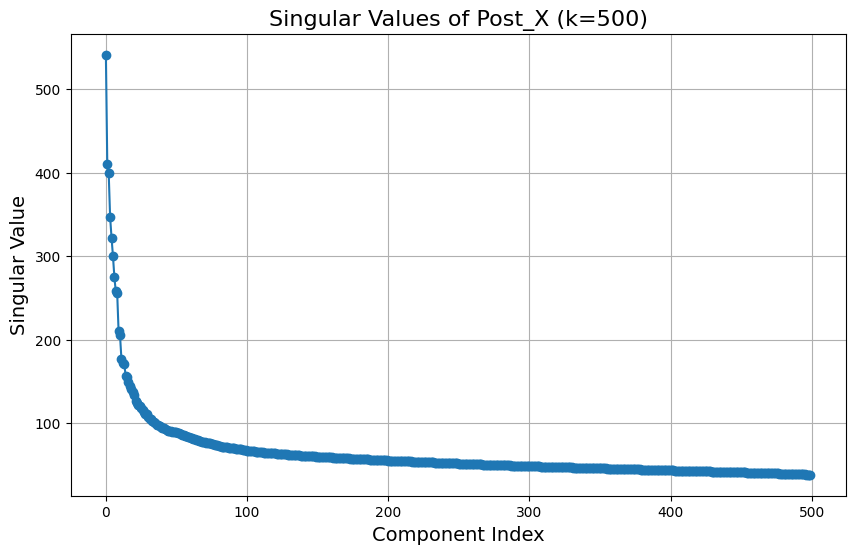

In [41]:
# your code here

# svd.singular_values_
def plot_svd(svd):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(svd.singular_values_)), svd.singular_values_, '-o')
    plt.xlabel('Component Index', fontsize=14)
    plt.ylabel('Singular Value', fontsize=14)
    plt.title('Singular Values of Post_X (k=500)', fontsize=16)
    plt.grid(True)
    plt.show()

plot_svd(svd)

#### 1.8
rubric= {accuracy:3,quality:1, efficiency:1}

At this point, you have two matrix representations of the data:

1. Original BOW representation (`post_X_norm`)
2. SVD with k=500 (`post_X_500`)

You will now create two more matrix representations of the data:

3. SVD with k=n, where $n$ is based on your elbow analysis from 1.7 (this will have $n$ columns)
4. SVD version using the columns between $n$ and 500. (this will have 500 - $n$ columns)

You can create 3 and 4 just by slicing `post_X_500`; you don't need to run TruncatedSVD again.

Then, do the same kind of consistency analysis you did in 1.3, but this time using each of matrices 2, 3, and 4. Again, you are creating 10 clusterings for each, and then exhaustively pairing those 10 with each other and checking their consistency using the adjusted rand score.

Your final experiment here will involve testing the clustering label consistency between 1 (the original dataset) and each of the three other matrices. Instead of exhaustively pairing a list of clusterings derived from a single representation (as you did in 1.3 and directly above) to check how consistent the clusterings are, you will be exhaustively pairing two lists of 10 clusterings, one list of clusterings derived using Matrix 1 (i.e. the original representation), and one of clusterings from one of the other three matrices (in 1.3 you were doing comparisons analogous to "pdist", whereas here you are doing something analogous to "cdist"). 

This should result in 3 average consistency values, one for each of matrices 2, 3, and 4, which you should take as a measure of how well each representation is able to preserve the information in the original for the purposes of clustering. With the results for 2, 3, and 4 for the internal consistency testing, you should be displaying a total of 6 numbers here, make sure you clearly identify which is which! For full points, use functions, and try to avoid redoing the same clustering again and again.

In [46]:
# your code here

def get_pairwise_ari(n, X1, X2):
    
    # 1. Initialize Lists for Clustering Results
    kmeanses1 = []
    kmeanses2 = []

    # 2. Run MiniBatchKMeans on X1 and X2
    for i in range(n):
        kmeans1 = MiniBatchKMeans(n_clusters=30, batch_size=50, max_no_improvement=50, random_state=i).fit(X1)
        kmeans2 = MiniBatchKMeans(n_clusters=30, batch_size=50, max_no_improvement=50, random_state=i).fit(X2)
        kmeanses1.append(kmeans1.labels_)
        kmeanses2.append(kmeans2.labels_)

    # 3. Compute Pairwise ARIs
    aris = []
    for i in range(n):
        for j in range(i+1, n):
            aris.append(adjusted_rand_score(kmeanses1[i], kmeanses2[j]))

    # 4. Return the average ARI
    return sum(aris)/len(aris)

In [47]:
# Prepare `post_X_500` using TruncatedSVD
svd = TruncatedSVD(n_components=500, random_state=0)
post_X_500 = svd.fit_transform(post_X_norm)

# Determine `n` based on elbow method
n = 50

# Prepare `post_X_0_to_50` and `post_X_50_to_500`
post_X_0_to_50 = post_X_500[:, :n]
post_X_50_to_500 = post_X_500[:, n:500]

print("Internal consistency:")
print("Mean ARI 0-500:", get_ari(10, post_X_500))
print("Mean ARI 0-50:", get_ari(10, post_X_0_to_50))
print("Mean ARI 50-500:", get_ari(10, post_X_50_to_500))
print()

print("Consistency with original matrix X_norm:")
print("Mean pairwise ARI 0-500:", get_pairwise_ari(10, post_X_500, post_X_norm))
print("Mean pairwise ARI 0-50:", get_pairwise_ari(10, post_X_0_to_50, post_X_norm))
print("Mean pairwise ARI 50-500:", get_pairwise_ari(10, post_X_50_to_500, post_X_norm))
print()

Internal consistency:
Mean ARI 0-500: 0.3596024353099056
Mean ARI 0-50: 0.3889865101892922
Mean ARI 50-500: 0.05494705192554139

Consistency with original matrix X_norm:
Mean pairwise ARI 0-500: 0.3937042505895092
Mean pairwise ARI 0-50: 0.03612607689321647
Mean pairwise ARI 50-500: 0.0002734238307480625



#### 1.9
rubric= {reasoning:2}

Interpret the relative performance of the three vector representations based on what you understand about SVD. In particular, you should discuss whether your choice of k from 1.7 (using the elbow method) seems to be a good one, in terms of preserving the information contained in the original document representation.

**Answer:**

From the results, we can see that the first 50 principal components (0-50) of SVD can capture the core features of the data well, have high internal consistency (0.39), and achieve a good balance between dimensionality reduction efficiency and information retention. The subsequent principal components (50-500) mainly contain low-variance features or noise, and their consistency and information retention effects are extremely low (0.05 and close to 0). Overall, it is reasonable to choose a dimension of `k=30` based on the elbow rule, which not only effectively reduces the dimension but also retains enough information for clustering, but may lose some consistency with the details of the original matrix.

### Part 2: Topic modelling


#### 2.1
rubric={accuracy:1}

Using the blog data, build an LDA model with 100 topics. Use online learning, and set the verbosity option to 2 and evaluate_every to 1, so the you can see the process of training and the perplexity after each iteration. Increase the total number of iterations and run again if perplexity has not converged (you can say it has coveraged if there is less than a 5 point drop in perplexity in the final iteration). This will take a while (probably at least half an hour), so work on something else while you wait....  It may also make sense after you get it working to dump the results to a file, so you don't have to run this every time you start up the kernel...

Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. *Journal of Machine Learning Research*, 3(4–5), 993–1022.

For `post_X`:
- `LatentDirichletAllocation`: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- 100 topics `n_components`,
- use `"online"` as a `learning_method`
- `verbosity` option = **0**, otherwise, it prints A LOT. 
- `evaluate_every` = 1

In [48]:
# your code here, takes time to run... (>13min)

# Building the LDA model with 100 topics
lda = LatentDirichletAllocation(
    n_components=100,          # Number of topics
    learning_method="online",  # Use online learning
    max_iter=50,               # Start with 50 iterations
    random_state=0,            # Reproducibility
    evaluate_every=1,          # Evaluate perplexity after each iteration
    verbose=0
)

# Fit the LDA model to the original post_X data
lda.fit(post_X)

# Output perplexity after the final iteration
final_perplexity = lda.perplexity(post_X)
final_perplexity

np.float64(4668.053048781353)

#### 2.2
rubric={accuracy:3}

For each topic in the model, print out the topic number (0 to 99), the sum of the corresponding row of components_ (the total psuedo counts for that topic), and the 15 words which have the highest number of psuedocounts (in components_) for that topic, high count word first. **Hint:** the CountVectorizer that you built in Part 0 will be needed here, because you can use it to translate feature index numbers into words. 

You should exclude topic words which have a psuedocount of less than 5. It's possible that some topics end up with an empty list of words after filtering filter step, but that's okay.

In [50]:
# Your code here

def print_topics(lda_model, vectorizer, top_n=15, min_count=5):
    """
    Print topics from an LDA model with top words and their pseudocounts.

    Parameters:
    - lda_model: Trained LDA model (LatentDirichletAllocation).
    - vectorizer: Fitted CountVectorizer to map indices to words.
    - top_n: Number of top words to display for each topic (default=15).
    - min_count: Minimum pseudocount to include a word in the topic (default=5).
    """
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        # Calculate the total pseudocounts for the topic
        topic_sum = topic.sum()

        # Filter and sort words based on pseudocounts
        filtered_words = [
            (feature_names[i], topic[i])
            for i in topic.argsort()[::-1]  # Sort by descending pseudocounts
            if topic[i] >= min_count
        ]

        # Extract the top N words
        top_words = filtered_words[:top_n]

        # Display topic information
        print(f"Topic number: {topic_idx}, {topic_sum}")
        if top_words:
            print([word for word, count in top_words])
        else:
            print("[]")
        print()

In [51]:
print_topics(lda, vectorizer)

Topic number: 0, 3244.333642148209
['da', 'de', 'angel', 'y', 'que', 'el', 'kate', 'max', 'se', 'un', 'sharon', 'te', 'bald', 'ü', 'har']

Topic number: 1, 320555.25304718333
['car', 'morning', 'week', 'decided', 'hours', 'finally', 'hour', 'minutes', 'asked', 'wasn', 'weekend', 'bit', 'saw', '10', '30']

Topic number: 2, 17762.535713104662
['music', 'song', 'band', 'songs', 'cd', 'rock', 'guitar', 'concert', 'play', 'sing', 'album', 'singing', 'listening', 'listen', 'played']

Topic number: 3, 6511.197909348428
['beach', 'ride', 'trip', 'hotel', 'road', 'river', 'park', 'island', 'tour', 'fireworks', 'miles', 'swimming', 'headed', 'sea', 'beautiful']

Topic number: 4, 149.39000000017614
[]

Topic number: 5, 3636.3156605642985
['room', 'living', 'walls', 'bedroom', 'paint', 'wood', 'closet', 'painted', 'yard', 'fridge', 'furniture', 'carpet', 'storage', 'curtains', 'project']

Topic number: 6, 1843.7387188342286
['player', 'canada', 'canadian', 'russian', 'canadians', 'russia', 'stack'

#### 2.3
rubric={raw:2}

Next, pick an appropriate topic label for those topics from the list you just created that you judge to be a "good" topic. Look for topics where you can identify a clear theme in their words (it is okay if there a few words that don't make sense - remember, this is still unsupervised!), and where the sum of psuedocounts is fairly high but not too high (There are always a few "kitchen sink" garbage topics). You should create a dictionary which maps from the label to the index: e.g. 

`topic_dict = {"animals":0, "geography":1, ...}`

In [62]:
# Your code here to make your dict "manually"

# Manually selected topic labels based on the earlier analysis
topic_dict = {
    # Social and personal life
    "daily_life": 1,            # Words about daily activities and time (e.g., 'morning', 'week', 'hour')
    "music": 2,                 # Words about music and bands (e.g., 'music', 'song', 'band')
    "travel": 3,                # Words about travel and locations (e.g., 'beach', 'trip', 'hotel')
    "home_and_decor": 5,        # Words about home and interior design (e.g., 'room', 'walls', 'paint')

    # Arts, culture, and media
    "religion_and_beliefs": 10, # Words about religion and spirituality (e.g., 'god', 'church', 'faith')
    "books_and_movies": 14,     # Words about literature and films (e.g., 'movie', 'book', 'reading')
    "art_and_photography": 82,  # Words about creative arts and photography (e.g., 'art', 'camera', 'photos')

    # Sports and games
    "sports": 42,               # Words about sports and games (e.g., 'game', 'team', 'match')

    # Food and drinks
    "food": 23,                 # Words about food and cooking (e.g., 'chicken', 'milk', 'bread')

    # Technology and the internet
    "technology": 17,           # Words about computers and the web (e.g., 'computer', 'internet', 'use')

    # Politics and society
    "politics": 50,             # Words about politics and war (e.g., 'war', 'president', 'america')
    "family_and_relationships": 51, # Words about family life (e.g., 'dad', 'mom', 'kids')
    "finance": 84,              # Words about money and business (e.g., 'money', 'job', 'market')

    # Education
    "education": 99,            # Words about education and students (e.g., 'students', 'bus', 'drivers')
}

#### 2.4
rubric={accuracy:3,quality:1}

Build a retrieval system which takes a list of topics like `["technology", "food"]` (i.e. a query) and displays documents from your corpus which contain the desired set of topics. 

Your (main) function should take a list of topics, and the number of top-ranked matches you want to see. You should only display texts whose topic proportions are 2 standard deviations above the topic proportion mean, that is, a z-score greater than 2 for all topics in the query. Your function should return the count of all texts which meet this bar in addition to the actual results. 

The ranking of the displayed documents should be based on the z-score among the topics asked for, i.e. a higher z-score is better. When there are multiple topics in the same query, you should use the *lowest* z-score among the topic z-scores for comparison. E.g. let's say the query contains the topics `["technology", "food"]`, and the z-score of `doc1` is 2.1 for `"tecnhology"` and 3.5 for `"food"`, and the z-score for `doc2` is 2.2 for `"technology"` and 2.3 for `"food"`. Then, `doc2` should be ranked higher in the results.

Print out a few examples that show that your retreival system is working, including at least one case with multiple topics.

**Hint:** [scipy.stats.zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html), note that you should specify the axis or flatten your data into a 1-dimensional array.

In [63]:
from scipy.stats import zscore
# A z-score measures exactly how many standard deviations above or below the mean a data point is.

MIN_Z_SCORE = 2

# your code here
def get_topics(post_X, data, topic_list, n_texts, topic_dict):
    """
    Retrieve documents matching the given topics.

    Parameters:
    - post_X: Document-topic matrix (output of LDA.transform).
    - data: Original document texts (list of strings).
    - topic_list: List of topic labels to search for.
    - n_texts: Number of top-ranked matches to display.
    - topic_dict: Dictionary mapping topic labels to topic indices.

    Returns:
    - Total count of matching documents.
    - List of top `n_texts` matching documents.
    """
    # Get the topic indices for the query
    topic_indices = [topic_dict[t] for t in topic_list]

    # Transform the document matrix to topic proportions
    topic_proportions = lda.transform(post_X)

    # Calculate z-scores for each topic
    zscores = zscore(topic_proportions, axis=0)

    matches = []  # List to store matches (min z-score, document)

    for post, doc_zscores in zip(data, zscores):
        # Check if all query topics have z-scores >= MIN_Z_SCORE
        if all(doc_zscores[topic_idx] >= MIN_Z_SCORE for topic_idx in topic_indices):
            # Use the lowest z-score among the query topics for ranking
            min_zscore = min(doc_zscores[topic_idx] for topic_idx in topic_indices)
            matches.append((min_zscore, post))

    # Sort matches by the minimum z-score in descending order
    matches.sort(reverse=True, key=lambda x: x[0])

    # Return total count and top `n_texts` matches
    return len(matches), [match[1] for match in matches[:n_texts]]

In [64]:
get_topics(post_X, posts, "food technology".split(), 3, topic_dict)

(1,
 ["\r\n\r\n\t \r\n      The loonies in Kulitibank have been trying to pry my PHMNL password from me for weeks since I resigned. I have no idea what PHMNL means but giving access to it is practically like handing over a gun to someone who wants to assassinate me.   Why they want to get it is beyond me. The only thing remotely related to incriminating evidence they will find in my corporate email inbox are my work-related angsts, my pictures and my MP3s. Name one person in Kulitibank who doesn�t have any of the three in his PC and I will gladly write William Hung�s name using my butt.    Operation: Get Password  was carried out by Cruella de Ville, Oilve Oyl's sneaky and manipulative sidekick. Cruella is officially the �Junior IC� (a.k.a.  alalay ) but more often than not, she�s Olive Oyl�s hatchet woman.    Attempt No. 1  (On my cellphone)  Cruella: Heeeey, you know what, I can�t access the files in the laptop you surrendered�  Glenville: Naturally, Cruella. That�s because you don�t

#### 2.5 (Optional)
rubric={accuracy:1}

Modify your code above to print out the top 5 ranked words for each topic in the query for each result, and rerun your examples.

**Hint:** the CountVectorizer that you built in Part 0 will be needed here, because you can use it to translate feature index numbers into words. 

In [ ]:
# your code here



#### 2.6 (Optional)
rubric={reasoning:1}

Play around with your topic search engine using a diversity of topic combinations, and print out two results lists that you find which have at least one correct and one incorrect result (incorrect meaning that at least one of the topics cannot be applied properly to the passage). Explain why you think the incorrect results happened, with reference to the limitations of the LDA model or perhaps errors in your topic naming.

In [ ]:
topic_dict

In [ ]:
# your code here


### Exercise 3: Report
rubric={reasoning:3, writing:1}

After you have finished your lab, look back, and determine which methods were most successful, and which were not.  Does one method take more time than another?  Does one take more tuning of hyperparameters?  Is it worth the extra time / effort?  Write at least 2 paragraphs describing how these unsupervised methods compare with the supervised methods you've seen in your other classes. Finally, think about how you might be able to incorporate semi-supervised learning into topic-modeling.  It doesn't have to be state-of-the-art - I just want you to think about how you might go about it.

Furthermore, as always, report which members of the team were responsible for which sections of the lab.  Did you do team coding, or did you assign certain parts of the lab to each other?  How did you arrive at this decision?  

**Answer:**

This lab explored topic modeling and cluster analysis of text data through unsupervised learning methods such as K-means and LDA. The K-means method is efficient and suitable for quickly exploring data distribution, but it is sensitive to initial parameters and requires dimensionality reduction to improve the performance of high-dimensional data; although LDA topic modeling takes a long time to train and requires more hyperparameter adjustments, it can generate more semantically interpretable topics and is suitable for text analysis tasks. Compared with supervised methods, unsupervised methods do not require labels but the results are more difficult to verify. They are suitable for exploring unknown patterns or providing inspiration for supervised learning. In the future, the model effect can be further improved by combining semi-supervised learning (such as introducing some known labels), reducing the cost of parameter adjustment and training while improving the accuracy of topic modeling.

I (Yi) and Lingsong worked together this lab. Lingsong mainly responsible for the first part while I mainly responsible for the second part. After each one of us finished our own part, we firstly go through our code and logic of solving questions to the each other. This guaranteed each of us fully comprehend the whole lab. After we done each part, we push to our own branch and let the other one to confirm the pull request on github. 